<a href="https://colab.research.google.com/github/juankuntz/ParEM/blob/main/jax/bayesian_logistic_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Description:** This notebook demonstrates the application of PGD, PQN, PMGD, SOUL, and VI to the Bayesian latent space network model from Hoff et al. (2002). 

# Latent space network model - Game of Thrones

First, we load the modules that we will need:

In [1]:
#@title Load modules.

# Install the wget package on Colab (if running the notebook locally,
# comment the following line out).
#!pip install wget

# OS and wget to load dataset.
import os
from scipy.stats import norm
from scipy.spatial.distance import pdist, squareform
from scipy.spatial import procrustes

# Numpy for computations.
import numpy as np
import jax.numpy as jnp
from jax import grad, jit, vmap
from jax import random

key = random.PRNGKey(0)

# Pyplot for plots.
import matplotlib.pyplot as plt 

In [34]:
from load_got import load_got

# Load GoT character interaction networks
Y, names = load_got(seasons=[1,2,3,4], weight_min=10)
y = jnp.asarray(Y[3])

#Remove the rows and columns which contain only zero entries, i.e. degree=0
names = names[np.where(np.sum(y,1)!=0)[0]]
ytemp = np.delete(y,np.where(np.sum(y,1)==0),0)
y = np.delete(ytemp,np.where(np.sum(ytemp,0)==0),1)


In [3]:
#log-target density p_theta(y,x)
def log_target(th, z):
    #dist = jnp.matmul(z,z.T)/jnp.linalg.norm(z,axis=1)
    dist = jnp.sqrt(jnp.sum((z[None, :] - z[:, None])**2, -1)+10e-6)
    eta = th - dist
    log_prior =  -jnp.sum(jnp.dot(z.T,z))  
    log_lik = jnp.sum(jnp.multiply(y,eta) - jnp.log1p(jnp.exp(eta)))
    return log_lik + log_prior

We then implement the algorithms. They take the following inputs:

*   y : n x n adjacency matrix,
*   Z : n x D latent positions
*   K : number of steps,
*   N : number of particles,
*   th : 1-dimensional vector with parameter guess,
*   X : D x N matrix storing the initial particle cloud.

They return the following outputs:

*   th : K-dimensional vector of parameter estimates,
*   X : D x (KN) matrix storing the particle clouds (the kth cloud is X[:, (k-1)$^\ast$N : k$^\ast$N]).

In [12]:
#@title Implement algorithms

# Algorithms.

def vi(l, f, h, K, N, th, X, mu=None):
  D = f[0, :].size  # Extract latent variable dimension.
  mu = np.zeros(D) if mu is None else mu
  z = np.ones(D)
  for k in range(K):
    # update q
    def loss(mu, z):
      s2 = softplus(z)
      x = (np.random.normal(0, 1, (N, D)) * s2 ** 0.5  + mu).T
      log_prior =  - np.sum((x - th[k]) ** 2, 0) / 5  # Shape (N)
      log_likel =  l * np.matmul(f, x) - np.log(1 + np.exp(np.matmul(f, x)))  # (M, N)
      log_prob = np.sum(log_likel, 0)
      entropy = 0.5 * np.sum(np.log(s2))
      return np.mean(log_prob + log_prior, 0) + entropy
    step_size = h
    mu, z = mu + step_size * grad(loss, 0)(mu, z), z + step_size * grad(loss, 1)(mu, z)
    s2 = softplus(z)
    Xk = (np.random.normal(0, 1, (N, D)) * s2 ** 0.5 + mu).T
    # update theta
    th = np.append(th, th[k] + h*ave_grad_th(th[k], Xk))
    X = np.append(X, Xk, axis=1) # Store updated cloud.
  return th, X, mu, softplus(z)


def pgd(y, h, K, N, th, X):
    D = X[:,:,0].shape  # Extract latent variable dimension.
    
    for k in range(K):
        #Update particle cloud:
        Xkp1 = np.copy(X)
        gx = [grad_x(th[k],X[:,:,i]) for i in range(N)]
        for i in range(N):
            Xkp1[:,:,i] =  X[:,:,i] + h*gx[i] + np.sqrt(2*h)*np.random.normal(0, 1, D)
        X = np.copy(Xkp1)
        th = np.append(th, th[k] + h*np.mean([grad_alpha(th[k],X[:,:,i]) for i in range(N)]))  # Update theta.
    return th, X

#Coin version of the PGD function
def coin(y, K, N, th, X):
    theta0 = np.copy(th)
    x_shape = X.shape
    X0 = X.reshape(-1,X.shape[-1])

    # initialise other vars for X and theta
    L_theta, L_X = 0, 0
    grad_theta_sum, grad_Xk_sum = 0, 0
    reward_theta, reward_X = 0, 0
    abs_grad_theta_sum, abs_grad_Xk_sum = 0, 0
    for k in range(K):
        Xk = X.reshape(-1,X.shape[-1])  # Extract current particle cloud.
        # Update particle cloud:
        
        # calculate kernel matrix
        kxy, dx_kxy = svgd_kernel(Xk, h=-1)

        # gradient
        gx = [grad_x(th[k],X[:,:,i]).flatten() for i in range(N)]
        grad_Xk = (np.matmul(kxy, np.asarray(gx).T) + dx_kxy) 

        # |gradient|
        abs_grad_Xk = abs(grad_Xk)

        # constant
        L_X = np.maximum(abs_grad_Xk, L_X)

        # sum of gradients
        grad_Xk_sum += grad_Xk
        abs_grad_Xk_sum += abs_grad_Xk

        # 'reward'
        reward_X = np.maximum(reward_X + np.multiply(Xk - X0, grad_Xk), 0)

        # X update
        Xkp1 = X0 + grad_Xk_sum / (L_X * (abs_grad_Xk_sum + L_X)) * (L_X + reward_X)
        
        X = Xkp1.reshape(x_shape)
        
        # Update theta:
        # gradient
        grad_theta = np.mean([grad_alpha(th[k],X[:,:,i]) for i in range(N)]) 

        # |gradient|
        abs_grad_theta = abs(grad_theta)

        # constant
        L_theta = np.maximum(abs_grad_theta, L_theta)

        # sum of gradients
        grad_theta_sum += grad_theta
        abs_grad_theta_sum += abs_grad_theta

        # 'reward'
        reward_theta = np.maximum(reward_theta + np.multiply(th[k] - theta0, grad_theta), 0)

        # theta update
        th = np.append(th, theta0 + grad_theta_sum / (L_theta * (abs_grad_theta_sum + L_theta)) * (L_theta + reward_theta))  # Update theta.
    return th, X



# Auxiliary functions.

def svgd_kernel(theta, h = -1):
    sq_dist = pdist(theta)
    pairwise_dists = squareform(sq_dist) ** 2

    # if h < 0, using median trick
    if h < 0:
        h = np.median(pairwise_dists)
        h = np.sqrt(0.5 * h / np.log(theta.shape[0] + 1))

    # rbf kernel
    kxy = np.exp(-pairwise_dists / h ** 2 / 2)

    # rbf kernel grad
    dx_kxy = -np.matmul(kxy, theta)
    sum_kxy = np.sum(kxy, axis=1)

    for i in range(theta.shape[1]):
        dx_kxy[:, i] = dx_kxy[:, i] + np.multiply(theta[:, i], sum_kxy)

    dx_kxy = dx_kxy / (h ** 2)

    return kxy, dx_kxy

def procrustes_transform(X, mle):
    Xtrans = np.copy(X)
    for i in range(N):
        _, Xtrans[:,:,i], _ = procrustes(mle, X[:,:,i])    
    return Xtrans
 
grad_alpha = grad(log_target, 0)
grad_x = grad(log_target,1)

## Run the various algorithms and plot the latent representation

We run the algorithms using an 80/20 training/test split of the data:

In [5]:
#Find the MLE
D = y.shape[0]

# Initialize parameter estimates and particle cloud, all at zero:
th0 = jnp.array([[1.0]])  # Parameter estimate.
key, x_key = random.split(key, 2)


th = th0
x = 0.1*random.normal(x_key,(D, 2))

lr = 0.01
for step in range(10000):
    x_grad = grad_x(th,x)
    x += lr*x_grad
    th_grad = grad_alpha(th,x) 
    th += lr*th_grad
    if step % 1000 == 0:
        print('Log_target', log_target(th,x))
        print('alpha',th)
Xmle = x
Xmle, _ ,_ = procrustes(random.normal(x_key,(D, 2)), x)  

Log_target -10308.652
alpha [[-31.618065]]
Log_target -798.88416
alpha [[0.19081044]]
Log_target -759.45197
alpha [[0.45906997]]
Log_target -741.5118
alpha [[0.5576849]]
Log_target -730.4495
alpha [[0.59934175]]
Log_target -722.9768
alpha [[0.61719036]]
Log_target -717.531
alpha [[0.6242491]]
Log_target -713.5285
alpha [[0.62787104]]
Log_target -710.54816
alpha [[0.6277789]]
Log_target -708.2368
alpha [[0.62658596]]


In [13]:
# Set approximation parameters:
h = 1e-2 # Step-size. 
K = 500  # Number of steps.
N = 10  # Number of particles.
D = y.shape[0]

# Initialize parameter estimates and particle cloud, all at zero:
th0 = th  # Parameter estimate.
key, x_key = random.split(key, 2)
X0 = 0.01*random.normal(x_key,(D, 2, N))
for i in range(N):
    X0.at[:,:,i].set(X0[:,:,i]+Xmle)

# Run algorithms:
#th_vi, X_vi, m_vi, s_vi = vi(ltrain, ftrain, h, K, N, th0, X0)
th_pgd, X_pgd = pgd(y, h, K, N, th0, X0)
th_coin, X_coin = coin(y, K, N, th0, X0)
  
#Procrustes transformation - post-processing step
X_pgd = procrustes_transform(X_pgd, Xmle)
X_coin = procrustes_transform(X_coin, Xmle)

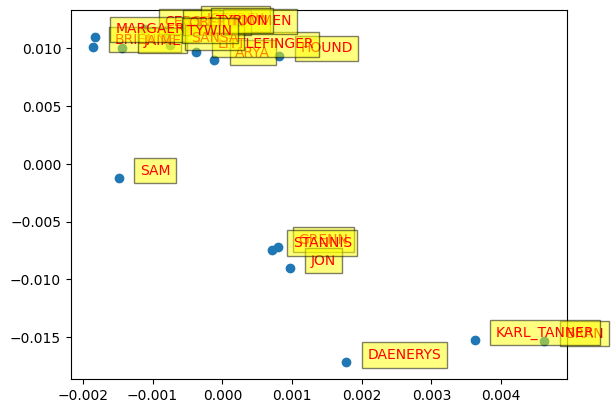

In [18]:
import pandas as pd

avg_X_coin = jnp.mean(X_coin,axis=2)
avg_X_pgd = jnp.mean(X_pgd,axis=2)

indx = jnp.sum(y,1)>4
plotting_index = np.where(indx*np.arange(D)!=0)[0]

plt.scatter(avg_X_coin[plotting_index,0],avg_X_coin[plotting_index,1])

for i in plotting_index:
    jitter = 0.0003#*np.random.randn()
    plt.text(x=avg_X_coin[i,0]+jitter,y=avg_X_coin[i,1]+jitter,s=names[i],fontdict=dict(color='red',size=10),bbox=dict(facecolor='yellow',alpha=0.5))

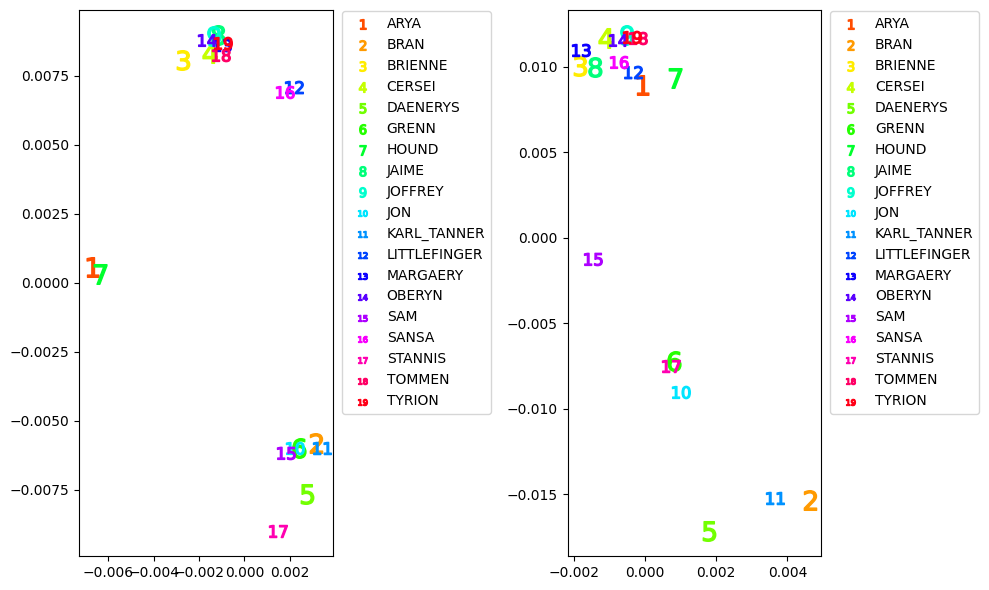

In [53]:
#Alternative plotting

n = np.arange(1, len(plotting_index))
x_y_colours = plt.get_cmap('hsv')(n / n.max())
x_y_labels = names[plotting_index]

fig, ax = plt.subplots(1,2,figsize=(10,6))
for xi, yi, color_i, label_i, txt in zip(avg_X_pgd[plotting_index,0], avg_X_pgd[plotting_index,1], x_y_colours, x_y_labels, n):
    ax[0].scatter(xi, yi, marker=f'${txt}$', s=200, color=color_i, label=label_i)
ax[0].legend(markerscale=0.5, bbox_to_anchor=[1.01, 1.01], loc='upper left')
for xi, yi, color_i, label_i, txt in zip(avg_X_coin[plotting_index,0], avg_X_coin[plotting_index,1], x_y_colours, x_y_labels, n):
    ax[1].scatter(xi, yi, marker=f'${txt}$', s=200, color=color_i, label=label_i)
ax[1].legend(markerscale=0.5, bbox_to_anchor=[1.01, 1.01], loc='upper left')
plt.tight_layout()
plt.show()

And plot the parameter estimates as a function of k:

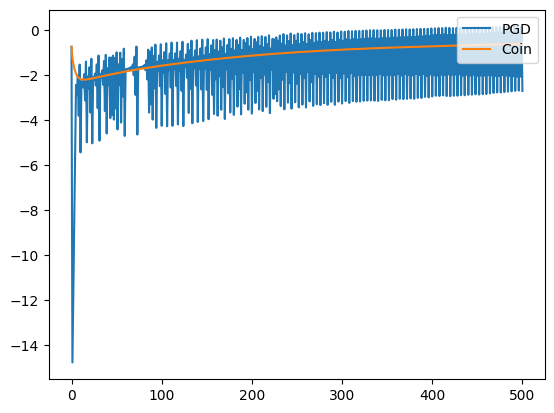

In [19]:
#plt.plot(th_vi, label='VI')
plt.plot(th_pgd, label='PGD')
#plt.xlim([-K/100, K])
plt.plot(th_coin, label='Coin')
plt.legend(loc='upper right')

The estimates produced by all five algorithms converge to the same limit after similar transients. To observe more significant differences between the algorithms' outputs, we examine the posterior approximations they return...